### In this project, we will do model comparison on four Dark Matter density profiles. We will test which models fits the galaxy rotational curve best.

### Model
Model 

$ M $ = The rotational curve calculated with the existence of dark matter and the dark matter density is given by the density profile. We have four dark matter density files and give us 4 models to compare. 

The posterior distribution is calculated as, $ p(M|D,I) = \frac{p(M|I) p(D|M, I)}{p(D|I)} $



### The four Dark Matter density profiles models: 

Note that

r: galactocentric radius

$ \rho( r ) $ : Dark Matter Density as a function of galactocentric radius


### (1) NFW profile :

 $ \rho \left( r \right) \propto \frac{1}{{\left( r/a \right)}{\left[ 1~+~{{\left( r/a \right)}} \right]}^{2}} $


### (2) Isothermal profile:

  $  \rho \left( r \right) \propto \frac{1}{{\left[ 1~+~{{\left( r/a \right)}^{2}} \right]}} $


### (3) Einasto profile :

 $ \rho \left( r \right) \propto \exp^{- A r ^\alpha} $


### (4) Generalized DM profile :

 $ \rho \left( r \right) \propto    \frac{1}{{\left( r/a \right)}^{\gamma}{\left[ 1~+~{{\left( r/a \right)}^{\alpha}} \right]}^{ \frac{(\beta - \gamma)}{\alpha}}} $



### We can calcuate rotational curve from Dark Matter density profiles, by assuming dark matter distribution is spherically symmetric

$ \frac{GMm}{4 \pi  R^2} = \frac {m v^2}{R}$  where $M=\int_{R_o}^{R} \rho (r) 4 \pi  R^2 dr$

$v_{calculated} = \sqrt { \frac{ G   \int_{R_o}^{R} \rho (r) 4 \pi  r^2 dr} {4 \pi  r}  }   $



In [1]:
import numpy as np
import nestle
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import corner
from scipy.integrate import quad
import nsdmd
import pandas as pd

In [2]:
# Define the data for two references:
# Reference 1: Bhattacharjee et. al.
# Reference 2: Sofue 
### The data will be used in this project is the measured rotational speed of the interstellar medium in our local galaxy, as shown in the following figure. 



#load data
data_x_ref1,data_xerr_ref2,data_y_ref1,data_yerr_ref1 =nsdmd.load_data('dataref1.txt')
data_x_ref2,data_xerr_ref2,data_y_ref2,data_yerr_ref2 =nsdmd.load_data2('dataref2.txt')

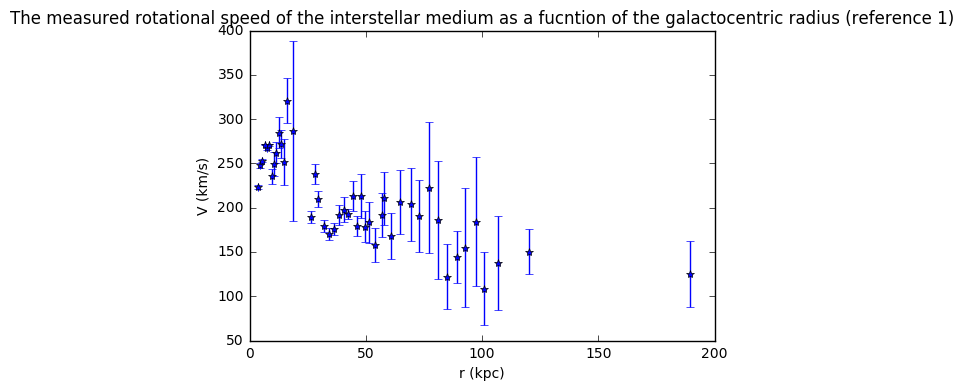

In [3]:
data_xerr = 0
plt.figure()
plt.errorbar(data_x_ref1,data_y_ref1,xerr=data_xerr,yerr=data_yerr_ref1,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 1)")
plt.show()

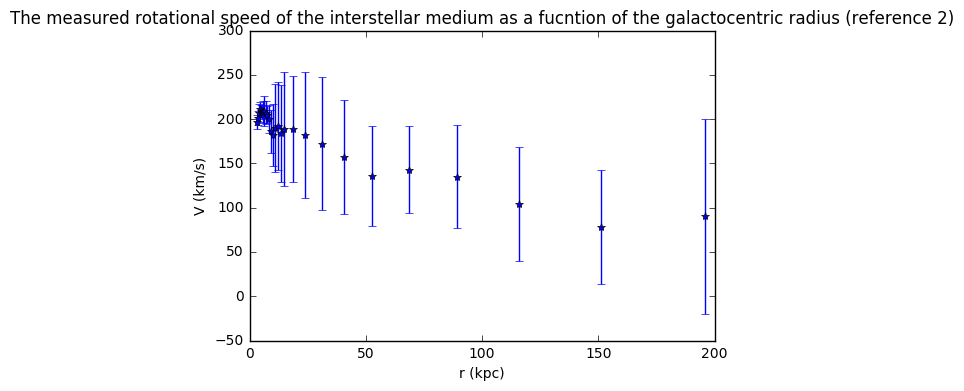

In [4]:
data_xerr = 0
plt.figure()
plt.errorbar(data_x_ref2,data_y_ref2,xerr=data_xerr,yerr=data_yerr_ref2,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 2)")
plt.show()

### The log likelihood is meant to capture how well a model is able to reproduce the data that it is meant to simulate.

$log p(D|M, I) = constant* \prod_{i}^{} log(\sigma_i)  \sum_{i}{}(\frac{(v_{icalculated} - v_{imeasured})^2}{2 \sigma_i^2}) $

$constant* \prod_{i}^{} log(\sigma_i) $, this part doesn't matter much since they are the same for all. 

$log p(D|M, I) =  \sum_{i}{}(\frac{(v_{icalculated} - v_{imeasured})^2}{2 \sigma_i^2}) $

In [5]:
# Define the model we use to describe the data.

def model_NFW(theta, x):
    
    # Calculate the mass between 0 and data_x by integrating the NFW distribution.
    #
    # Note: the mass defined here does not include the normalization constant rho0 (kg/kpc^3).
    # The units of a are kpc.
    # The units of the "mass" calculated here are thus kpc^3.
    a = theta[0]
    mass = 4.*np.pi*(a**3)*(np.log((a+x)/a)-x/(a+x))
        
    # Calculate the rotation velocity: vrot = theta[1]*sqrt(mass/x)
    # The units of sqrt(mass/x) are kpc.
    # The rotation velocity is equal to sqrt(G*rho0)*sqrt((M/rho0)/x) where M is the mass enclosed, 
    # rho0 is the normalization constant of the mass distribution, and x is the distance at which we
    # calculate vrot.
    # When we determine theta[1], we determine sqrt(G*rho0).
    # The units of vrot are km/s.
    # The units of sqrt(mass/x) are kpc.
    # The units of theta[1] are thus (km/s)/kpc = (10^3 m)/s/(3.086E19 m) = 3.24E-17 1/s.
    # Since theta[1] = sqrt(G*rho0) we can now determine rho0: rho0 = theta[1]^2/G.
    # The units on the right-hand side are: (3.24E-17 1/s)^2/(m^3/(kg s^2)) = (3.24E-17)^2 kg/(m^3)
    # To convert from kg/m^3 to kg/kpc^3, we multiply by (3.086E19)^3
    # The normalization constant rho0 is thus (theta1[1]^2)/6.67E-11 * ((3.24E-17)^2 * (3.086E19)^3 kg/(kpc)^3 = 
    # (theta1[1]^2)*4.625E35 kg/(kpc)^3 = 2.312E5 Msun/(kpc)^3.
    vrot = theta[1]*np.sqrt(mass/x) 
    
    return vrot

In [6]:
# Define a likelihood function
def loglike_NFW_ref1(theta):
    
    # Calculate the mass between 0 and data_x by integrating the NFW distribution.
    a = theta[0]
    mass = 4.*np.pi*(a**3)*(np.log((a+data_x_ref1)/a)-data_x_ref1/(a+data_x_ref1))
        
    # Calculate the rotation velocity.
    vrot = theta[1]*np.sqrt(mass/data_x_ref1) 
        
    # The y variable is the rotational velocity.
    y = vrot
    
    # Calculate chisq
    chisq= np.sum(((data_y_ref1 - y) / data_yerr_ref1)**2)
    return -chisq / 2.



In [7]:
# Define a likelihood function
def loglike_NFW_ref2(theta):
    
    # Calculate the mass between 0 and data_x by integrating the NFW distribution.
    a = theta[0]
    mass = 4.*np.pi*(a**3)*(np.log((a+data_x_ref2)/a)-data_x_ref2/(a+data_x_ref2))
        
    # Calculate the rotation velocity.
    vrot = theta[1]*np.sqrt(mass/data_x_ref2) 
        
    # The y variable is the rotational velocity.
    y = vrot
    
    # Calculate chisq
    chisq= np.sum(((data_y_ref2 - y) / data_yerr_ref2)**2)
    return -chisq / 2.


### The prior: 
uniform priors with constraints from literature. 
  

In [8]:
# It is a transformation from a space where variables are independently and uniformly distributed between 0 and 1 to the parameter space of interest. 
# 


def prior_transform_NFW(theta):
    
    # theta[0] in the range of [0,10] and theta[1] in the range of [0,300]
    return  np.array([20, 300]) * theta
    #return  np.array([10*theta[0],500*theta[1]])


Therefore, we can calculated the posterior $ p(M|D,I) = \frac{p(M|I) p(D|M, I)}{p(D|I)} $ and compare the posterior by MCMC and/or Nestle to do model comparison. 

By using the Nestle package, it will give us log evidence, numerical (sampling) error on logz, array of sample parameters, array of weights associated with each sampleand result.weights. 

In [9]:
# Run nested sampling.

# Start with reference 1

result_ref1 = nestle.sample(loglike_NFW_ref1, prior_transform_NFW, 2)

print ('Number of iterations for Data in Reference 1')
print (result_ref1.niter)

print ('log evidence for Data in Reference 1')
print (result_ref1.logz)

print ('numerical (sampling) error on logz for Data in Reference 1')
print (result_ref1.logzerr)   
       
print ('array of sample parameters for Data in Reference 1')
print (result_ref1.samples)  
       
#print ('array of weights associated with each sample for Data in Reference 1')
#print (result_ref1.weights)

# Continue with reference 2

result_ref2 = nestle.sample(loglike_NFW_ref2, prior_transform_NFW, 2)

print ('Number of iterations for Data in Reference 2')
print (result_ref2.niter)

print ('log evidence for Data in Reference 2')
print (result_ref2.logz)

print ('numerical (sampling) error on logz for Data in Reference 2')
print (result_ref2.logzerr)   
       
print ('array of sample parameters for Data in Reference 2')
print (result_ref2.samples)  
       
#print ('array of weights associated with each sample for Data in Reference 2')
#print (result_ref2.weights)


Number of iterations for Data in Reference 1
1234
log evidence for Data in Reference 1
-280.750337363
numerical (sampling) error on logz for Data in Reference 1
0.3246668055168492
array of sample parameters for Data in Reference 1
[[  19.14825326  293.17506141]
 [  19.54879364  287.32981587]
 [  16.293748    294.1235709 ]
 ..., 
 [   3.29405214   49.13357677]
 [   3.34340815   48.37458169]
 [   3.37876976   47.88108091]]
Number of iterations for Data in Reference 2
841
log evidence for Data in Reference 2
-8.6416077848
numerical (sampling) error on logz for Data in Reference 2
0.25489927445725324
array of sample parameters for Data in Reference 2
[[  17.92976454  289.1543186 ]
 [  18.45588132  277.08462311]
 [  17.36533671  282.08992594]
 ..., 
 [   2.34114578   53.67481477]
 [   2.10086967   59.96411933]
 [   2.8812396    43.5595519 ]]


Results based on fits to the data from reference 1:
Core radius a =  3.32 +/-  0.10 kpc
Normalization factor = 48.82 +/-  1.47
Halo density normalization constant = 1.13e+07 +/- 3.40e+05 Msun/kpc^3
Halo density in our solor system = 6.17e+07 Msun/kpc^3.
Halo density in our solor system = 2.35e+03 GeV/c^2/liter.


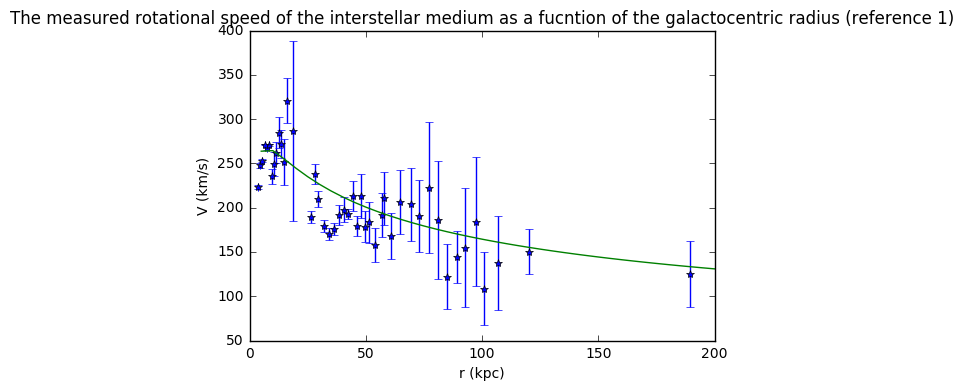

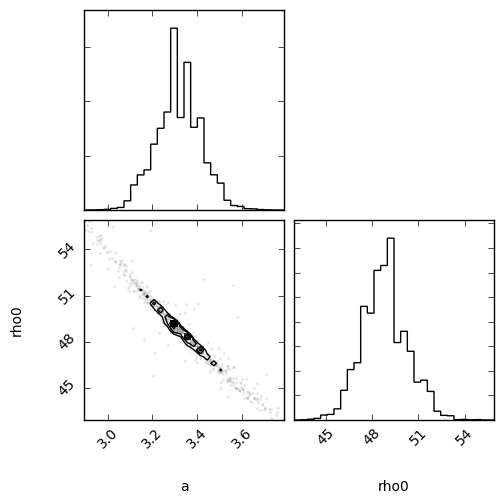

Results based on fits to the data from reference 1:
Core radius a =  2.53 +/-  0.56 kpc
Normalization factor = 52.24 +/- 12.13
Halo density normalization constant = 1.21e+07 +/- 2.80e+06 Msun/kpc^3
Halo density in our solor system = 4.98e+07 Msun/kpc^3.
Halo density in our solor system = 1.90e+03 GeV/c^2/liter.


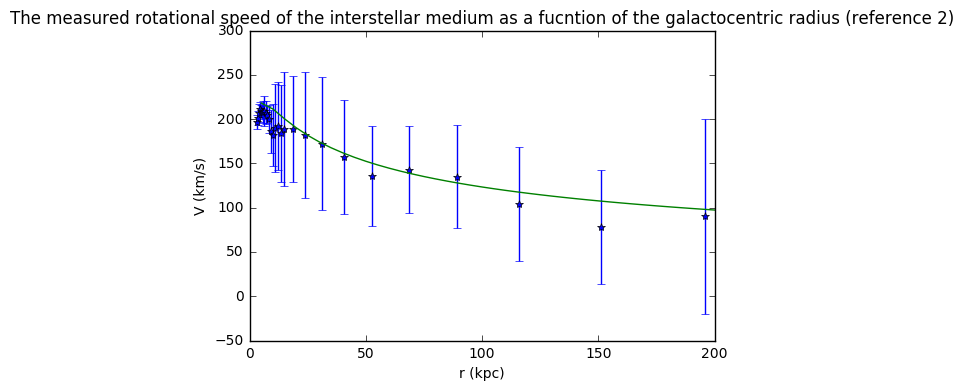

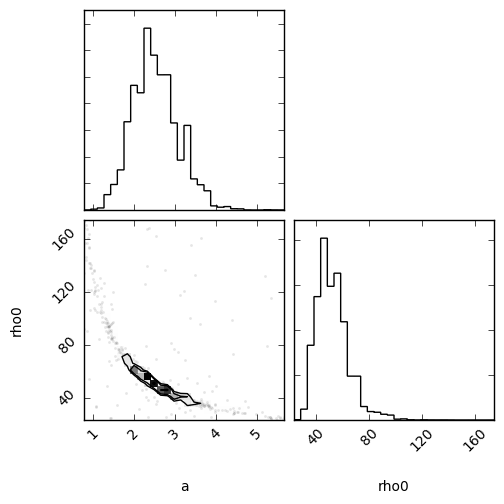

In [10]:
data_xerr = 0

# Get the results of the fit and the uncertainties in the fit parameters.
p_ref1, cov_ref1 = nestle.mean_and_cov(result_ref1.samples, result_ref1.weights)
p_ref2, cov_ref2 = nestle.mean_and_cov(result_ref2.samples, result_ref2.weights)

# Start with printing the results of the fit based on the data from reference 1
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_ref1[0], np.sqrt(cov_ref1[0, 0])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f}".format(p_ref1[1], np.sqrt(cov_ref1[1, 1])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_ref1[1], 2.312E5*np.sqrt(cov_ref1[1, 1])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_NFW(p_ref1, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_NFW(p_ref1, 8)))

plt.figure()
plt.errorbar(data_x_ref1,data_y_ref1,xerr=data_xerr,yerr=data_yerr_ref1,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 1)")
xplot = [5+5*i for i in range(40)]
plt.plot(xplot,model_NFW(p_ref1, xplot))
plt.show()

fig = corner.corner(result_ref1.samples, weights=result_ref1.weights, labels=['a', 'rho0'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()


# Continue with printing the results of the fit based on the data from reference 2
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_ref2[0], np.sqrt(cov_ref2[0, 0])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f}".format(p_ref2[1], np.sqrt(cov_ref2[1, 1])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_ref2[1], 2.312E5*np.sqrt(cov_ref2[1, 1])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_NFW(p_ref2, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_NFW(p_ref2, 8)))

plt.figure()
plt.errorbar(data_x_ref2,data_y_ref2,xerr=data_xerr,yerr=data_yerr_ref2,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 2)")
xplot = [5+5*i for i in range(40)]
plt.plot(xplot,model_NFW(p_ref2, xplot))
plt.show()

fig = corner.corner(result_ref2.samples, weights=result_ref2.weights, labels=['a', 'rho0'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()

In [11]:
def model_Isothermal(theta, x):
    a = theta[0]
    mass = 4.*np.pi*(a**3)*(np.log((a+x)/a)-x/(a+x))      
    vrot = theta[1]*np.sqrt(mass/x)   
    return vrot

def loglike_IsothermalProfile_ref1 (theta):
    #theta[1] is the constant proportional factor 
    density_IsothermalProfile =   1/( 1+data_x_ref1 /theta[0] )**2 
    y=theta[1] * 1
    chisq = np.sum(((data_y_ref1 - y) / data_yerr_ref1)**2)
    return -chisq / 2.

def loglike_IsothermalProfile_ref2 (theta):
    #theta[1] is the constant proportional factor 
    density_IsothermalProfile =   1/( 1+data_x_ref2 /theta[0] )**2 
    y=theta[1] * 1
    chisq = np.sum(((data_y_ref2 - y) / data_yerr_ref2)**2)
    return -chisq / 2.

def prior_transform_Isothermal(theta):
    
    # theta[0] in the range of [0,10] and theta[1] in the range of [0,300]
    return  np.array([20, 300]) * theta
    #return  np.array([10*theta[0],500*theta[1]])
    
#Run nested sampling.

# Start with reference 1

result_ref1 = nestle.sample(loglike_IsothermalProfile_ref1, prior_transform_Isothermal, 2)

print ('Number of iterations for Data in Reference 1')
print (result_ref1.niter)

print ('log evidence for Data in Reference 1')
print (result_ref1.logz)

print ('numerical (sampling) error on logz for Data in Reference 1')
print (result_ref1.logzerr)   
       
print ('array of sample parameters for Data in Reference 1')
print (result_ref1.samples)  
       
#print ('array of weights associated with each sample for Data in Reference 1')
#print (result_ref1.weights)

# Continue with reference 2

result_ref2 = nestle.sample(loglike_IsothermalProfile_ref2, prior_transform_Isothermal, 2)

print ('Number of iterations for Data in Reference 2')
print (result_ref2.niter)

print ('log evidence for Data in Reference 2')
print (result_ref2.logz)

print ('numerical (sampling) error on logz for Data in Reference 2')
print (result_ref2.logzerr)   
       
print ('array of sample parameters for Data in Reference 2')
print (result_ref2.samples)  
       
#print ('array of weights associated with each sample for Data in Reference 2')
#print (result_ref2.weights)

Number of iterations for Data in Reference 1
616
log evidence for Data in Reference 1
-844.879039465
numerical (sampling) error on logz for Data in Reference 1
0.21869398010283914
array of sample parameters for Data in Reference 1
[[   1.12394821    0.386857  ]
 [   7.89962371    8.24088726]
 [  19.60409795    8.70154007]
 ..., 
 [   5.69089162  263.25817741]
 [   9.78083749  263.32320355]
 [  12.45079994  263.39171556]]
Number of iterations for Data in Reference 2
460
log evidence for Data in Reference 2
-12.0137390211
numerical (sampling) error on logz for Data in Reference 2
0.1768208009837208
array of sample parameters for Data in Reference 2
[[  10.82581977    8.42381953]
 [  18.95144186   18.46322883]
 [   8.21492161   26.87625859]
 ..., 
 [  13.42434045  204.29452304]
 [   8.12992717  205.05582088]
 [   4.6725076   203.11750828]]


Results based on fits to the data from reference 1:
Core radius a =  9.73 +/-  5.41 kpc
Normalization factor = 263.30 +/-  0.45
Halo density normalization constant = 6.09e+07 +/- 1.04e+05 Msun/kpc^3
Halo density in our solor system = 8.93e+08 Msun/kpc^3.
Halo density in our solor system = 3.41e+04 GeV/c^2/liter.


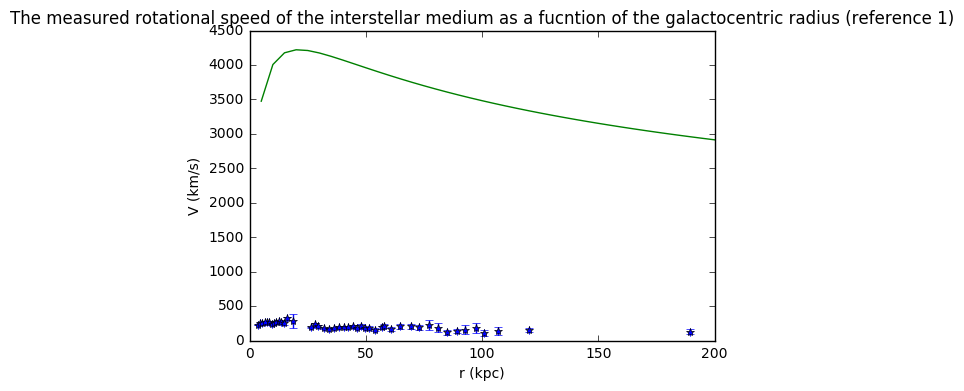

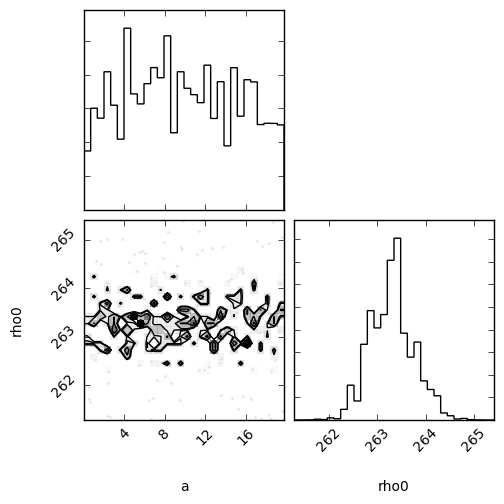

Results based on fits to the data from reference 1:
Core radius a = 10.21 +/-  6.10 kpc
Normalization factor = 203.66 +/-  2.90
Halo density normalization constant = 4.71e+07 +/- 6.71e+05 Msun/kpc^3
Halo density in our solor system = 7.18e+08 Msun/kpc^3.
Halo density in our solor system = 2.74e+04 GeV/c^2/liter.


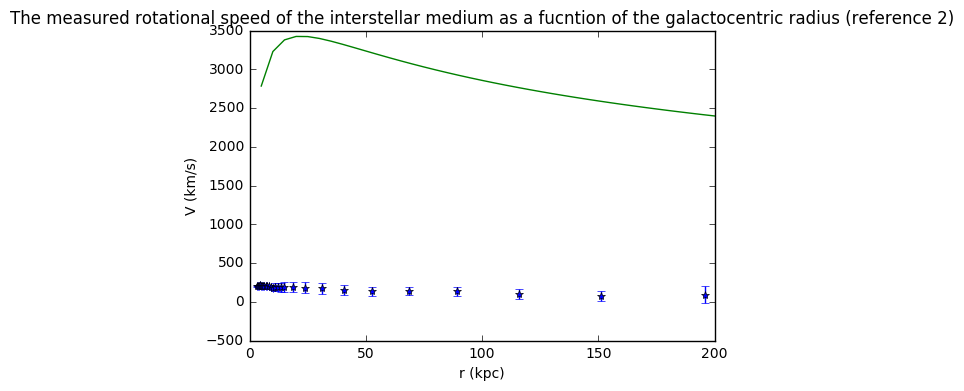

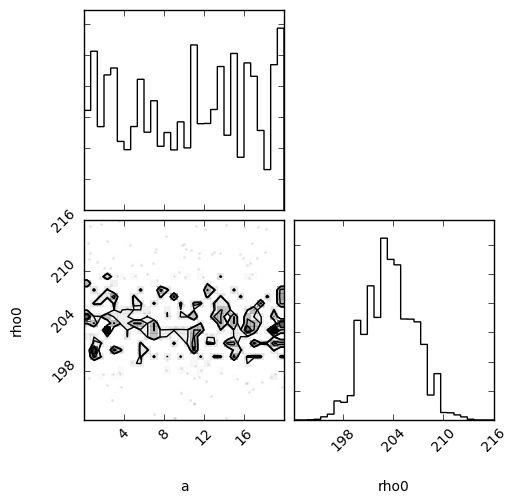

In [12]:
data_xerr = 0

# Get the results of the fit and the uncertainties in the fit parameters.
p_ref1, cov_ref1 = nestle.mean_and_cov(result_ref1.samples, result_ref1.weights)
p_ref2, cov_ref2 = nestle.mean_and_cov(result_ref2.samples, result_ref2.weights)

# Start with printing the results of the fit based on the data from reference 1
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_ref1[0], np.sqrt(cov_ref1[0, 0])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f}".format(p_ref1[1], np.sqrt(cov_ref1[1, 1])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_ref1[1], 2.312E5*np.sqrt(cov_ref1[1, 1])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_Isothermal(p_ref1, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_Isothermal(p_ref1, 8)))

plt.figure()
plt.errorbar(data_x_ref1,data_y_ref1,xerr=data_xerr,yerr=data_yerr_ref1,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 1)")
xplot = [5+5*i for i in range(40)]
plt.plot(xplot,model_Isothermal(p_ref1, xplot))
plt.show()

fig = corner.corner(result_ref1.samples, weights=result_ref1.weights, labels=['a', 'rho0'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()


# Continue with printing the results of the fit based on the data from reference 2
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_ref2[0], np.sqrt(cov_ref2[0, 0])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f}".format(p_ref2[1], np.sqrt(cov_ref2[1, 1])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_ref2[1], 2.312E5*np.sqrt(cov_ref2[1, 1])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_Isothermal(p_ref2, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_Isothermal(p_ref2, 8)))

plt.figure()
plt.errorbar(data_x_ref2,data_y_ref2,xerr=data_xerr,yerr=data_yerr_ref2,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 2)")
xplot = [5+5*i for i in range(40)]
plt.plot(xplot,model_Isothermal(p_ref2, xplot))
plt.show()

fig = corner.corner(result_ref2.samples, weights=result_ref2.weights, labels=['a', 'rho0'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()

In [13]:
def model_Einasto(theta, x):
    a = theta[0]
    mass = 4.*np.pi*(a**3)*(np.log((a+x)/a)-x/(a+x))      
    vrot = theta[1]*np.sqrt(mass/x)   
    return vrot

def loglike_EinastoProfile_ref1(theta):
    #theta[2] is the constant proportional factor 
    density_EinastoProfile = np.exp( -  theta[0]*  data_x_ref1**theta[1] ) 
    y=theta[2] *1
    chisq = np.sum(((data_y_ref1 - y) / data_yerr_ref1)**2)
    return -chisq / 2.

def loglike_EinastoProfile_ref2(theta):
    #theta[2] is the constant proportional factor 
    density_EinastoProfile = np.exp( -  theta[0]*  data_x_ref2**theta[1] ) 
    y=theta[2] *1
    chisq = np.sum(((data_y_ref2 - y) / data_yerr_ref2)**2)
    return -chisq / 2.

def prior_transform_Einasto(theta):
    
    # theta[0] in the range of [0,10] and theta[1] in the range of [0,300]
    return  np.array([20, 300]) * theta
    #return  np.array([10*theta[0],500*theta[1]])

Results based on fits to the data from reference 1:
Core radius a =  9.73 +/-  5.41 kpc
Normalization factor = 263.30 +/-  0.45
Halo density normalization constant = 6.09e+07 +/- 1.04e+05 Msun/kpc^3
Halo density in our solor system = 8.93e+08 Msun/kpc^3.
Halo density in our solor system = 3.41e+04 GeV/c^2/liter.


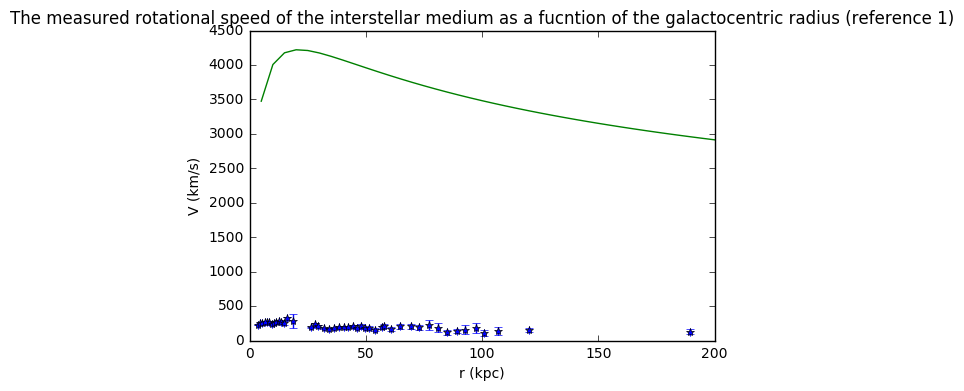

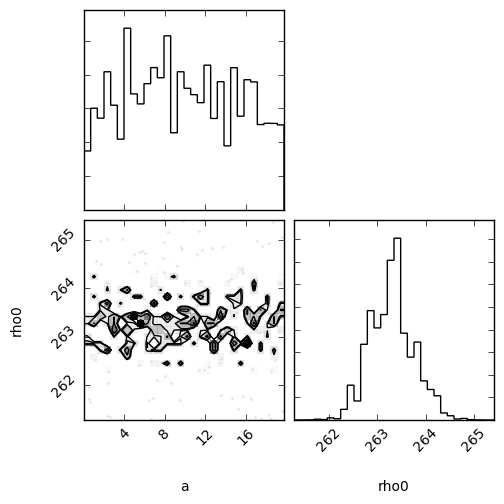

Results based on fits to the data from reference 1:
Core radius a = 10.21 +/-  6.10 kpc
Normalization factor = 203.66 +/-  2.90
Halo density normalization constant = 4.71e+07 +/- 6.71e+05 Msun/kpc^3
Halo density in our solor system = 7.18e+08 Msun/kpc^3.
Halo density in our solor system = 2.74e+04 GeV/c^2/liter.


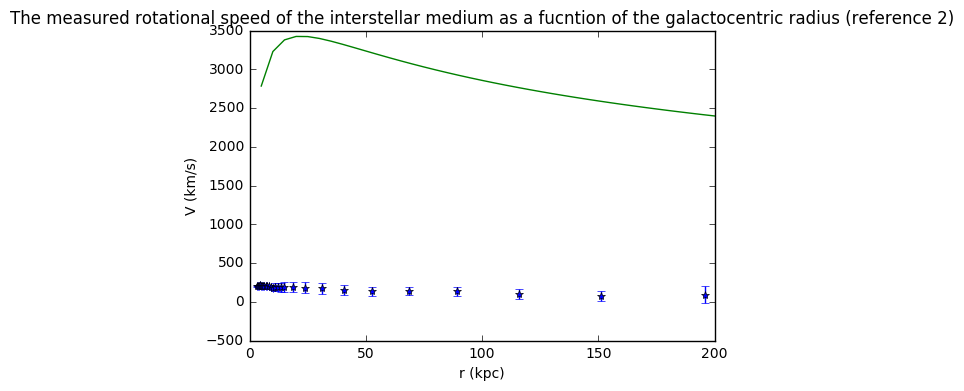

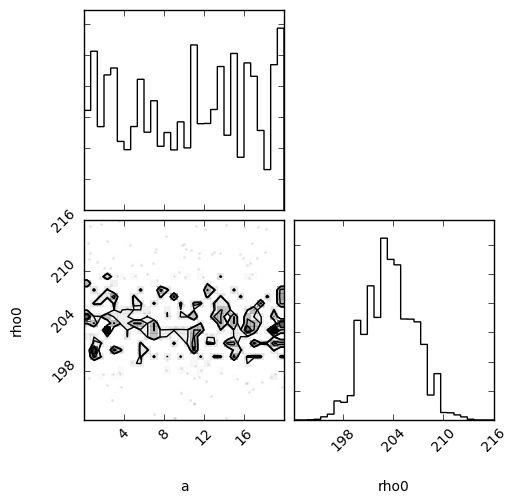

In [14]:
data_xerr = 0

# Get the results of the fit and the uncertainties in the fit parameters.
p_ref1, cov_ref1 = nestle.mean_and_cov(result_ref1.samples, result_ref1.weights)
p_ref2, cov_ref2 = nestle.mean_and_cov(result_ref2.samples, result_ref2.weights)

# Start with printing the results of the fit based on the data from reference 1
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_ref1[0], np.sqrt(cov_ref1[0, 0])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f}".format(p_ref1[1], np.sqrt(cov_ref1[1, 1])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_ref1[1], 2.312E5*np.sqrt(cov_ref1[1, 1])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_Einasto(p_ref1, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_Einasto(p_ref1, 8)))

plt.figure()
plt.errorbar(data_x_ref1,data_y_ref1,xerr=data_xerr,yerr=data_yerr_ref1,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 1)")
xplot = [5+5*i for i in range(40)]
plt.plot(xplot,model_Einasto(p_ref1, xplot))
plt.show()

fig = corner.corner(result_ref1.samples, weights=result_ref1.weights, labels=['a', 'rho0'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()


# Continue with printing the results of the fit based on the data from reference 2
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_ref2[0], np.sqrt(cov_ref2[0, 0])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f}".format(p_ref2[1], np.sqrt(cov_ref2[1, 1])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_ref2[1], 2.312E5*np.sqrt(cov_ref2[1, 1])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_Einasto(p_ref2, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_Einasto(p_ref2, 8)))

plt.figure()
plt.errorbar(data_x_ref2,data_y_ref2,xerr=data_xerr,yerr=data_yerr_ref2,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 2)")
xplot = [5+5*i for i in range(40)]
plt.plot(xplot,model_Einasto(p_ref2, xplot))
plt.show()

fig = corner.corner(result_ref2.samples, weights=result_ref2.weights, labels=['a', 'rho0'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()

In [15]:
def model_GeneralizedDM(theta, x):
    a = theta[0]
    mass = 4.*np.pi*(a**3)*(np.log((a+x)/a)-x/(a+x))      
    vrot = theta[1]*np.sqrt(mass/x)   
    return vrot

def loglike_GeneralizedDMProfile_ref1(theta):
    #theta[4] is the constant proportional factor 
    density_GeneralizedDMProfile = 1/(    (data_x_ref1 /theta[0])**theta[1] *( 1+ (data_x_ref1 /theta[0])**theta[2] )**2 ) **((theta[3] - theta[1])/theta[2] )
    y=theta[4] * 1
    chisq = np.sum(((data_y_ref1 - y) / data_yerr_ref1)**2)
    return -chisq / 2.

def loglike_GeneralizedDMProfile_ref2(theta):
    #theta[4] is the constant proportional factor 
    density_GeneralizedDMProfile = 1/(    (data_x_ref2 /theta[0])**theta[1] *( 1+ (data_x_ref2 /theta[0])**theta[2] )**2 ) **((theta[3] - theta[1])/theta[2] )
    y=theta[4] * 1
    chisq = np.sum(((data_y_ref2 - y) / data_yerr_ref2)**2)
    return -chisq / 2.

def prior_transform_GeneralizedDM(theta):
    
    # theta[0] in the range of [0,10] and theta[1] in the range of [0,300]
    return  np.array([20, 300]) * theta
    #return  np.array([10*theta[0],500*theta[1]])

Results based on fits to the data from reference 1:
Core radius a =  9.73 +/-  5.41 kpc
Normalization factor = 263.30 +/-  0.45
Halo density normalization constant = 6.09e+07 +/- 1.04e+05 Msun/kpc^3
Halo density in our solor system = 8.93e+08 Msun/kpc^3.
Halo density in our solor system = 3.41e+04 GeV/c^2/liter.


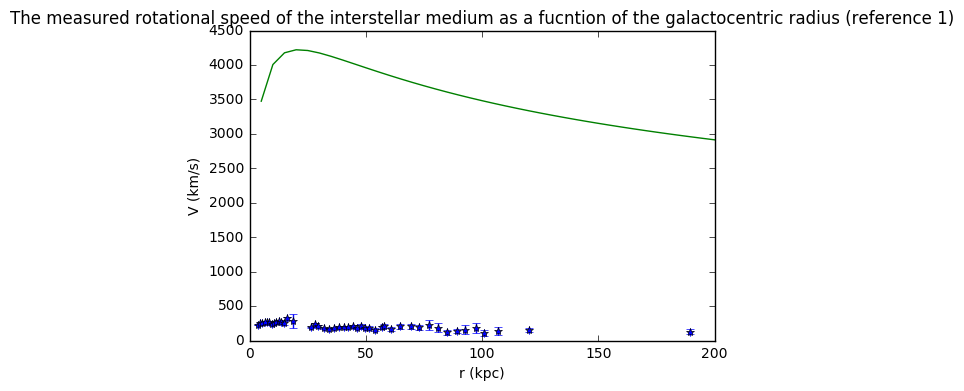

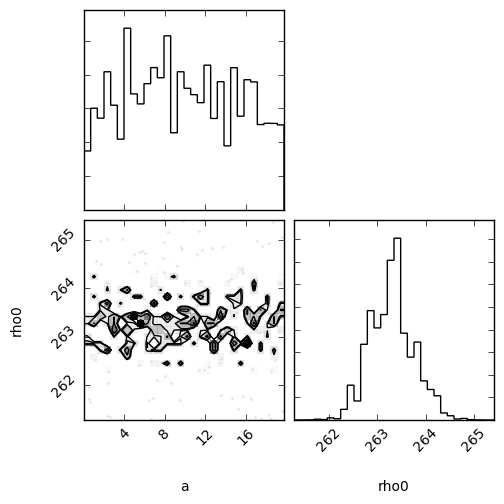

Results based on fits to the data from reference 1:
Core radius a = 10.21 +/-  6.10 kpc
Normalization factor = 203.66 +/-  2.90
Halo density normalization constant = 4.71e+07 +/- 6.71e+05 Msun/kpc^3
Halo density in our solor system = 7.18e+08 Msun/kpc^3.
Halo density in our solor system = 2.74e+04 GeV/c^2/liter.


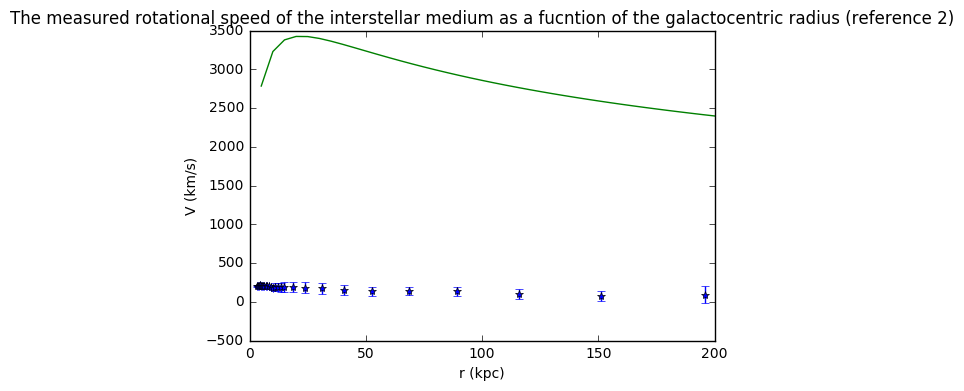

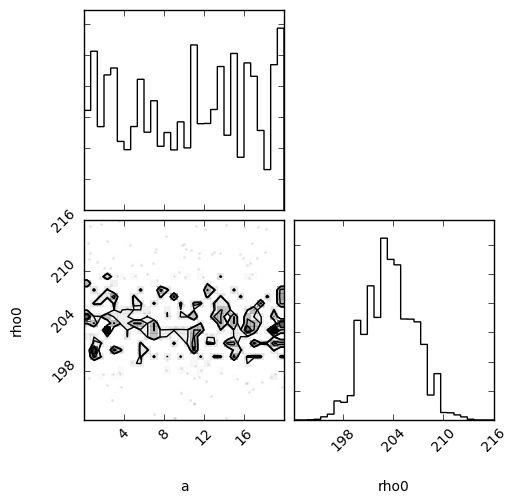

In [16]:
data_xerr = 0

# Get the results of the fit and the uncertainties in the fit parameters.
p_ref1, cov_ref1 = nestle.mean_and_cov(result_ref1.samples, result_ref1.weights)
p_ref2, cov_ref2 = nestle.mean_and_cov(result_ref2.samples, result_ref2.weights)

# Start with printing the results of the fit based on the data from reference 1
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_ref1[0], np.sqrt(cov_ref1[0, 0])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f}".format(p_ref1[1], np.sqrt(cov_ref1[1, 1])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_ref1[1], 2.312E5*np.sqrt(cov_ref1[1, 1])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_GeneralizedDM(p_ref1, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_GeneralizedDM(p_ref1, 8)))

plt.figure()
plt.errorbar(data_x_ref1,data_y_ref1,xerr=data_xerr,yerr=data_yerr_ref1,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 1)")
xplot = [5+5*i for i in range(40)]
plt.plot(xplot,model_GeneralizedDM(p_ref1, xplot))
plt.show()

fig = corner.corner(result_ref1.samples, weights=result_ref1.weights, labels=['a', 'rho0'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()


# Continue with printing the results of the fit based on the data from reference 2
print("Results based on fits to the data from reference 1:")
print("Core radius a = {0:5.2f} +/- {1:5.2f} kpc".format(p_ref2[0], np.sqrt(cov_ref2[0, 0])))
print("Normalization factor = {0:5.2f} +/- {1:5.2f}".format(p_ref2[1], np.sqrt(cov_ref2[1, 1])))
print("Halo density normalization constant = {0:5.2e} +/- {1:5.2e} Msun/kpc^3".format(2.312E5*p_ref2[1], 2.312E5*np.sqrt(cov_ref2[1, 1])))

# Note: in order to convert the model to units of Msun/kpc^3 we multiply its value by 2.312E5.
# See comments in the model definition for details.
print("Halo density in our solor system = {0:5.2e} Msun/kpc^3.".format(2.312E5*model_GeneralizedDM(p_ref2, 8)))

# Note: 1 Msun/kpc^3 = 3.817E-2 (GeV/c^2)/m^3 = 3.817E-5 (GeV/c^2)/(dm^3)
# 1 dm^3 = 1 liter.
# 3 WIMPS/liter would be 300 GeV/c^2/liter
print("Halo density in our solor system = {0:5.2e} GeV/c^2/liter.".format(3.817E-5*2.312E5*model_GeneralizedDM(p_ref2, 8)))

plt.figure()
plt.errorbar(data_x_ref2,data_y_ref2,xerr=data_xerr,yerr=data_yerr_ref2,fmt='*')
plt.xlabel("r (kpc)")
plt.ylabel('V (km/s)')
plt.title("The measured rotational speed of the interstellar medium as a fucntion of the galactocentric radius (reference 2)")
xplot = [5+5*i for i in range(40)]
plt.plot(xplot,model_GeneralizedDM(p_ref2, xplot))
plt.show()

fig = corner.corner(result_ref2.samples, weights=result_ref2.weights, labels=['a', 'rho0'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()

### Reference
[1] J. H. Oort. The force exerted by the stellar system in the direction perpendicular to the galactic plane and some related problems. Bull. Astr. Inst. Netherlands, 6:249, aug 1932.

[2] D. P. Clemens. Massachusetts-Stony Brook Galactic plane CO survey - The Galactic disk rotation curve. Astrophys. J. , 295:422–428, August 1985.

[3] V. C. Rubin, N. Thonnard, and W. K. Ford, Jr. Extended rotation curves of high-luminosity spiral galaxies. IV - Systematic dynamical properties, SA through SC. The Astrophysical Journal, 225:L107–L111, November 1978.

[4] F. Zwicky. Die Rotverschiebung von extragalaktischen Nebeln. Helvetica Physica Acta, 6:110–127, 1933.

[5] Douglas Clowe, Marusa Bradac, Anthony H. Gonzalez, Maxim Markevitch, Scott W. Randall, Christine Jones, and Dennis Zaritsky. A direct empirical proof of the existence of dark matter. Astrophys. J., 648:L109–L113, 2006.

[6] Maxim Markevitch. Chandra observation of the most interesting cluster in the universe. 2005. [ESA Spec. Publ.604,723(2006)].

[7] Composite Credit: X-ray: NASA/CXC/CfA/ M.Markevitch et al.; Lensing Map: NASA/STScI; ESO WFI; Magellan/ U.Arizona/ D.Clowe et al.; Optical: NASA/STScI; Magellan/ U.Arizona/D.Clowe et al.;.

[8] Pijushpani Bhattacharjee, Soumini Chaudhury, and Susmita Kundu. Rotation Curve of the Milky Way out to 200 kpc. Astrophys. J., 785:63, 2014.